In [1]:
import matplotlib.pyplot as plt
import numpy as np

from commpy.modulation import QAMModem

from optic.dsp import pulseShape, firFilter, decimate, symbolSync, resample
from optic.models import phaseNoise, KramersKronigRx, linFiberCh

from optic.tx import simpleWDMTx
from optic.core import parameters
from optic.equalization import edc, mimoAdaptEqualizer
from optic.carrierRecovery import cpr
from optic.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power
from optic.plot import pconst

import scipy.constants as const

### Simulation of a single polarization optical signal transmission

In [2]:
## Transmitter parameters:
paramTx = parameters()
paramTx.M = 16                 # order of the modulation format
paramTx.Rs = 32e9              # symbol rate [baud]
paramTx.SpS = 4                # samples per symbol
paramTx.Nbits = 400000         # total number of bits per polarization
paramTx.pulse = "rrc"          # pulse shaping filter
paramTx.Ntaps = 1024           # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.9         # RRC rolloff
paramTx.Pch_dBm = 0            # power of the optical signal [dBm]
paramTx.Nch = 1                # number of WDM channels
paramTx.Fc = 193.1e12          # central frequency of the optical spectrum
paramTx.freqSpac = 37.5e9      # WDM grid spacing

## Optical channel parameters:
Ltotal = 50      # total link distance [km]
alpha = 0        # fiber loss parameter [dB/km]
D = 16          # fiber dispersion parameter [ps/nm/km]
Fc = paramTx.Fc  # central optical frequency of the WDM spectrum [Hz]

## Receiver parameters:

# local oscillator (LO)
FO = 5e9 + paramTx.Rs/2  # frequency offset
lw = 0*200e3       # linewidth
ϕ_lo = 0           # initial phase in rad
Plo_dBm = 12        # power in dBm

# ADC sampling rate
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 4

## General simulation parameters:
chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

### Core simulation code

channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB


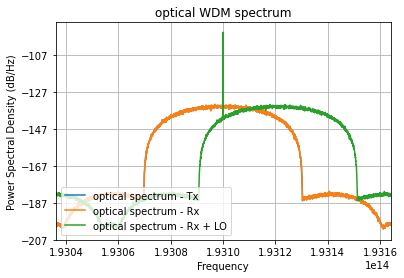

In [3]:
# generate optical signal signal
sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

# simulate linear signal propagation
sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)

# plots optical spectrum before and after transmission

# before
plt.figure()
plt.xlim(paramTx.Fc - Fs / 2, paramTx.Fc + Fs / 2)
plt.psd(
    sigTx[:, 0],
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Tx",
)

# after
plt.psd(
    sigCh,
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Rx",
)
plt.legend(loc="lower left")
plt.title("optical spectrum")

# receiver detection and demodulation

Fc = paramTx.Fc
Ts = 1 / Fs
mod = QAMModem(m=paramTx.M)

freqGrid = paramTx.freqGrid
print(
    "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
    % (
        chIndex,
        (Fc + freqGrid[chIndex]) / 1e12,
        const.c / (Fc + freqGrid[chIndex]) / 1e-9,
    )
)

symbTx = symbTx_[:, :, chIndex]

Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

print(
    "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
    % (Plo_dBm, lw / 1e3, FO / 1e6)
)

# generate LO field
π = np.pi
t = np.arange(0, len(sigCh))*Ts
ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

# Add LO to the received signal
sigRx = np.sqrt(Plo) + sigCh* np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
sfm   = sigRx.copy()

print('CSPR = %.2f dB'%(10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

# plot spectrum fter adding LO
plt.psd(
    sigRx,
    Fs=Fs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="optical spectrum - Rx + LO",
)
plt.legend(loc="lower left")
plt.title("optical WDM spectrum");

### Phase-retrieval stage

SIR =  12.43  dB


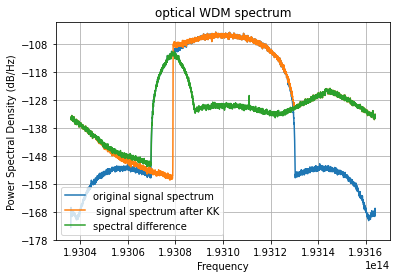

In [4]:
# resampling to ADC sampling rate
sigCh = resample(sigCh, paramADC)
sfm = resample(sfm, paramADC)
newFs = paramADC.SpS_out*paramTx.Rs

# simulate ideal direct-detection optical receiver
Amp = np.abs(sigRx)
Amp = resample(Amp, paramADC)

# Kramers-Kronig phase-retrieval
phiTime = KramersKronigRx(Amp, newFs)

# optical field reconstruction
sigRx = Amp*np.exp(1j*phiTime)

# remove DC level
sigRx -= np.sqrt(Plo)  # np.mean(sigRx)

# downshift to baseband
t = np.arange(0, len(sigRx))*(1/newFs)
sigRx *= np.exp(-1j * (2 * π * FO * t))

# plot spectrum of  the reconstructed field

# plot spectrum of  the reconstructed field
plt.psd(
    sigCh/np.sqrt(signal_power(sigCh)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="original signal spectrum",
)

plt.psd(
    sigRx/np.sqrt(signal_power(sigRx)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label=" signal spectrum after KK",
)

# correct for (possible) phase ambiguity
rot = np.mean(sigCh/sigRx)
sigRx = rot * sigRx
sigRx = sigRx / np.sqrt(signal_power(sigRx))

# plot spectrum of  the reconstructed field
plt.psd(
    sigRx/np.sqrt(signal_power(sigRx))-sigCh/np.sqrt(signal_power(sigCh)),
    Fs=newFs,
    Fc=paramTx.Fc,
    NFFT=4 * 1024,
    sides="twosided",
    label="spectral difference",
)
plt.legend(loc="lower left")
plt.title("optical WDM spectrum");

# calculate interference
intf = sigRx/np.sqrt(signal_power(sigRx))-sigCh/np.sqrt(signal_power(sigCh))

SIR = 1/signal_power(intf)

print('SIR = ', round(10*np.log10(SIR),2), ' dB')

#### Standard receiver processing

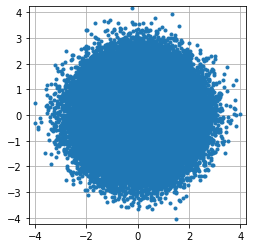

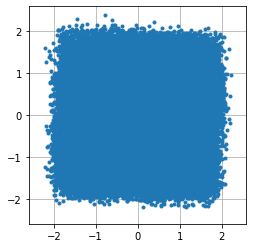

In [5]:
# resample to 2 samples/symbol:
paramRes = parameters()
paramRes.Rs = paramTx.Rs
paramRes.SpS_in = paramADC.SpS_out
paramRes.SpS_out = 2

sigRx = resample(sigRx, paramRes)

# Matched filtering and CD compensation

# Matched filtering
if paramTx.pulse == "nrz":
    pulse = pulseShape("nrz", paramADC.SpS_out)
elif paramTx.pulse == "rrc":
    pulse = pulseShape(
        "rrc", paramRes.SpS_out, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1 / paramTx.Rs
    )

pulse = pulse / np.max(np.abs(pulse))
sigRx = firFilter(pulse, sigRx)

# plot constellations after matched filtering
pconst(sigRx[0::paramRes.SpS_out], lim=True, R=3)

# CD compensation
sigRx = edc(sigRx, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)

#plot constellations after CD compensation
pconst(sigRx[0::paramRes.SpS_out], lim=True, R=2)

# Downsampling to 2 sps and re-synchronization with transmitted sequences
sigRx = sigRx.reshape(-1, 1)

symbRx = symbolSync(sigRx, symbTx, 2)



nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.026903.
nlms pre-convergence training iteration #1
nlms MSE = 0.010656.
nlms pre-convergence training iteration #2
nlms MSE = 0.008297.
nlms pre-convergence training iteration #3
nlms MSE = 0.007293.
nlms pre-convergence training iteration #4
nlms MSE = 0.006771.


dd-lms - training stage #1
dd-lms MSE = 0.005355.


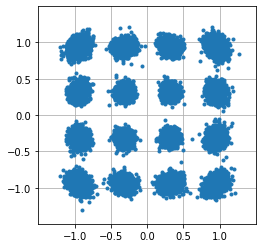

In [6]:
# Power normalization
x = sigRx
d = symbRx

x = x.reshape(len(x), 1) / np.sqrt(signal_power(x))
d = d.reshape(len(d), 1) / np.sqrt(signal_power(d))

# Adaptive equalization
mod = QAMModem(m=paramTx.M)

paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS = 2
paramEq.mu = [5e-3, 2e-3]
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.alg = ["nlms", "dd-lms"]
paramEq.M = paramTx.M
paramEq.L = [20000, 80000]

y_EQ, H, errSq, Hiter = mimoAdaptEqualizer(x, dx=d, paramEq=paramEq)

discard = int(paramEq.L[0]/2)

#plot constellations after adaptive equalization
pconst(y_EQ[discard:-discard, :], lim=True)

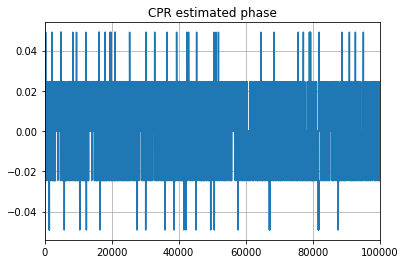

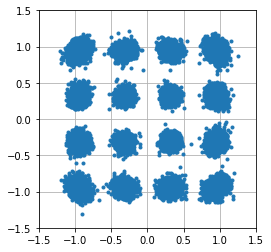

In [7]:
# Carrier phase recovery
paramCPR = parameters()
paramCPR.alg = "bps"
paramCPR.M = paramTx.M
paramCPR.N = 75
paramCPR.B = 64
paramCPR.pilotInd = np.arange(0, len(y_EQ), 20)

y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)

y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

plt.figure()
plt.title("CPR estimated phase")
plt.plot(θ, "-")
plt.xlim(0, len(θ))
plt.grid()

discard = 5000

# plot constellations after CPR
pconst(y_CPR[discard:-discard, :], lim=True)


#### Evaluate transmission metrics

In [8]:
# correct for (possible) phase ambiguity
for k in range(y_CPR.shape[1]):
    rot = np.mean(d[:, k] / y_CPR[:, k])
    y_CPR[:, k] = rot * y_CPR[:, k]

y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

ind = np.arange(discard, d.shape[0] - discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind, :], d[ind, :], mod)
GMI, _ = monteCarloGMI(y_CPR[ind, :], d[ind, :], mod)
MI = monteCarloMI(y_CPR[ind, :], d[ind, :], mod)

print("Results:\n")
print("SER: %.2e" % (SER[0]))
print("BER: %.2e" % (BER[0]))
print("SNR: %.2f dB" % (SNR[0]))
print("MI: %.2f bits" % (MI[0]))
print("GMI: %.2f bits" % (GMI[0]))

Results:

SER: 2.22e-05
BER: 5.56e-06
SNR: 22.66 dB
MI: 4.00 bits
GMI: 4.00 bits


In [9]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras import backend as K

### Getting the neural network model for each Rolloff value acquired with a fixed FO (Frequency Offset).

In [10]:
## Transmitter parameters:
paramTx = parameters()
paramTx.M = 16                 # order of the modulation format
paramTx.Rs = 32e9              # symbol rate [baud]
paramTx.SpS = 4                # samples per symbol
paramTx.Nbits = 400000         # total number of bits per polarization
paramTx.pulse = "rrc"          # pulse shaping filter
paramTx.Ntaps = 1024           # number of pulse shaping filter coefficients
# paramTx.alphaRRC = 0.9         # RRC rolloff
paramTx.Pch_dBm = 0            # power of the optical signal [dBm]
paramTx.Nch = 1                # number of WDM channels
paramTx.Fc = 193.1e12          # central frequency of the optical spectrum
paramTx.freqSpac = 37.5e9      # WDM grid spacing

## Optical channel parameters:
Ltotal = 50      # total link distance [km]
alpha = 0        # fiber loss parameter [dB/km]
D = 16          # fiber dispersion parameter [ps/nm/km]
Fc = paramTx.Fc  # central optical frequency of the WDM spectrum [Hz]

## Receiver parameters:

# local oscillator (LO)
# FO = 5e9 + paramTx.Rs/2  # frequency offset
lw = 0*200e3       # linewidth
ϕ_lo = 0           # initial phase in rad
Plo_dBm = 12        # power in dBm

# ADC sampling rate
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 4

## General simulation parameters:
chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

In [11]:
N = 256  # number of input amplitude samples to the NN

Rolloff = np.arange(0.01, 0.99, 0.1)
FO_Values = np.arange(1e9, 6e9, 1e9)

for indexFO, indFO_ in enumerate(FO_Values):
    for indNN, indNN_ in enumerate(Rolloff):
    
        # Main simulation parameters
        paramTx.alphaRRC = indNN_
        FO = indFO_ + paramTx.Rs/2

        # generate optical signal signal
        sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

        # simulate linear signal propagation
        sigCh = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)

        # receiver detection and demodulation
        Fc = paramTx.Fc
        Ts = 1 / Fs
        mod = QAMModem(m=paramTx.M)

        freqGrid = paramTx.freqGrid
        print(
            "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
            % (
                chIndex,
                (Fc + freqGrid[chIndex]) / 1e12,
                const.c / (Fc + freqGrid[chIndex]) / 1e-9,
            )
        )

        symbTx = symbTx_[:, :, chIndex]

        Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

        print(
            "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
            % (Plo_dBm, lw / 1e3, FO / 1e6)
        )

        # generate LO field
        π = np.pi
        t = np.arange(0, len(sigCh))*Ts
        ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

        sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

        # Add LO to the received signal
        sigRx = np.sqrt(Plo) + sigCh * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
        sfm = sigRx.copy()

        print('CSPR = %.2f dB' % (10*np.log10(signal_power(sigLO)/signal_power(sigCh))))

        # ### Phase-retrieval stage

        # In[4]:

        # resampling to ADC sampling rate
        sigCh = resample(sigCh, paramADC)
        sfm = resample(sfm, paramADC)
        newFs = paramADC.SpS_out*paramTx.Rs

        # simulate ideal direct-detection optical receiver
        Amp = np.abs(sigRx)
        Amp = resample(Amp, paramADC)

        sfm = sfm/np.sqrt(signal_power(sfm))
        
        sigPhase = np.angle(sfm)  # get signal phase samples (labels) (L,)
        sigAmp = np.pad(np.abs(sfm), (int(N/2), int(N/2)), 'constant') # get signal amplitude samples (L,)

        # create set of input features
        X_train = np.zeros((len(sigPhase), N))  # (L,N)
        y_train = sigPhase.copy()
        
        for indPhase in range(len(sigPhase)):
            X_train[indPhase] = sigAmp[indPhase:N+indPhase]

        # define neural network model
        stop = EarlyStopping(monitor='val_loss', patience=5)
        model = Sequential()
        model.add(BatchNormalization())
        model.add(Dense(4, input_shape=(N,)))
        model.add(Dense(8, activation='relu'))
        # model.add(Dense(8,activation='gelu'))
        model.add(Dense(4, activation='relu'))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')

        model.fit(X_train, y_train, epochs=100, callbacks=[stop],  validation_split=0.3, batch_size=256)

        model.summary()

        #cw1 = model.layers[1].get_weights()
        #plt.plot(cw1[0])
        
        # Save Model
        model.save('NN_models/testModel_SpS_'+str(paramADC.SpS_out)+'_FO_'+str(FO/10e9)+'GHz_Rolloff_'+str(round(paramTx.alphaRRC, 2)))

channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 25s 5ms/step - loss: 0.0131 - val_loss: 0.0027
Epoch 2/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 3/100
1094/1094 [==============================] - 5s 5ms/step - loss: 7.2316e-04 - val_loss: 5.3055e-04
Epoch 4/100
1094/1094 [==============================] - 5s 5ms/step - loss: 6.2894e-04 - val_loss: 4.0135e-04
Epoch 5/100
1094/1094 [==============================] - 5s 5ms/step - loss: 5.7752e-04 - val_loss: 3.3766e-04
Epoch 6/100
1094/1094 [==============================] - 5s 5ms/step - loss: 5.7526e-04 - val_loss: 3.6844e-04
Epoch 7/100
1094/1094 [==============================] - 5s 5ms/step - loss: 5.1155e-04 - v

INFO:tensorflow:Assets written to: NN_models/testModel_SpS_4_FO_1.7GHz_Rolloff_0.11\assets
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0322 - val_loss: 0.0035
Epoch 2/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 3/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 4/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 6/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/100
1094/1094 [==========

1094/1094 [==============================] - 5s 5ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 14/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 15/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 16/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 17/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 18/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 19/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 20/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 21/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 22/100
1094/1094 [==============================] - 5s 5ms/step - loss:

Epoch 4/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 5/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 6/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 7/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 8/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 9/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 10/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0039 - val_loss: 0.0039
Epoch 11/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0039 - val_loss: 0.0038
Epoch 12/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 13/100
1094/1094 [==============================] - 6s 5ms/step 

INFO:tensorflow:Assets written to: NN_models/testModel_SpS_4_FO_1.7GHz_Rolloff_0.71\assets
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 17000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0268 - val_loss: 0.0066
Epoch 2/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0062 - val_loss: 0.0057
Epoch 3/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 4/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 5/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0056 - val_loss: 0.0056
Epoch 6/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0056 - val_loss: 0.0055
Epoch 7/100
1094/1094 [============

1094/1094 [==============================] - 6s 5ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 20/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0057 - val_loss: 0.0055
Epoch 21/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 22/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 23/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 24/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0057 - val_loss: 0.0054
Epoch 25/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 26/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 27/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0056 - val_loss: 0.0054
Epoch 28/100
1094/1094 [==============================] - 6s 5ms/step - loss:

Epoch 98/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 99/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 100/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0048 - val_loss: 0.0045
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dense_36 (Dense)             (None, 4)                 1028      
_________________________________________________________________
dense_37 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense

1094/1094 [==============================] - 5s 5ms/step - loss: 6.5741e-04 - val_loss: 5.7727e-04
Epoch 6/100
1094/1094 [==============================] - 5s 5ms/step - loss: 6.2881e-04 - val_loss: 6.7073e-04
Epoch 7/100
1094/1094 [==============================] - 5s 5ms/step - loss: 6.1097e-04 - val_loss: 4.4396e-04
Epoch 8/100
1094/1094 [==============================] - 5s 5ms/step - loss: 5.8441e-04 - val_loss: 3.8640e-04
Epoch 9/100
1094/1094 [==============================] - 5s 5ms/step - loss: 5.6958e-04 - val_loss: 4.3730e-04
Epoch 10/100
1094/1094 [==============================] - 6s 5ms/step - loss: 5.7290e-04 - val_loss: 4.7631e-04
Epoch 11/100
1094/1094 [==============================] - 6s 5ms/step - loss: 5.3490e-04 - val_loss: 3.6560e-04
Epoch 12/100
1094/1094 [==============================] - 6s 5ms/step - loss: 5.2302e-04 - val_loss: 3.8066e-04
Epoch 13/100
1094/1094 [==============================] - 6s 5ms/step - loss: 5.3656e-04 - val_loss: 6.8580e-04
Epoch 14/

Epoch 27/100
1094/1094 [==============================] - 6s 5ms/step - loss: 9.0696e-04 - val_loss: 7.0846e-04
Epoch 28/100
1094/1094 [==============================] - 6s 5ms/step - loss: 9.1510e-04 - val_loss: 7.0910e-04
Epoch 29/100
1094/1094 [==============================] - 6s 5ms/step - loss: 9.1586e-04 - val_loss: 7.2027e-04
Epoch 30/100
1094/1094 [==============================] - 6s 5ms/step - loss: 9.1231e-04 - val_loss: 7.1024e-04
Epoch 31/100
1094/1094 [==============================] - 6s 5ms/step - loss: 9.0964e-04 - val_loss: 7.1012e-04
Epoch 32/100
1094/1094 [==============================] - 6s 5ms/step - loss: 8.9845e-04 - val_loss: 7.0728e-04
Epoch 33/100
1094/1094 [==============================] - 6s 5ms/step - loss: 9.0125e-04 - val_loss: 7.9482e-04
Epoch 34/100
1094/1094 [==============================] - 6s 5ms/step - loss: 8.9875e-04 - val_loss: 6.9161e-04
Epoch 35/100
1094/1094 [==============================] - 6s 5ms/step - loss: 8.9296e-04 - val_loss: 7.4

1094/1094 [==============================] - 6s 5ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 18/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 19/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 20/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 21/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 22/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 23/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 24/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0022 - val_loss: 0.0021
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_15 (Ba

Epoch 17/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 18/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0036 - val_loss: 0.0035
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
dense_68 (Dense)             (None, 4)                 1028      
_________________________________________________________________
dense_69 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_70 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 5         
Total params: 2,133
Trainable params: 1,621

1094/1094 [==============================] - 6s 5ms/step - loss: 0.0047 - val_loss: 0.0044
Epoch 24/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 25/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 26/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 27/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 28/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 29/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0045 - val_loss: 0.0044
Epoch 30/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 31/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0044 - val_loss: 0.0042
Epoch 32/100
1094/1094 [==============================] - 6s 5ms/step - loss:

1094/1094 [==============================] - 6s 5ms/step - loss: 3.2218e-04 - val_loss: 1.2932e-04
Epoch 19/100
1094/1094 [==============================] - 6s 5ms/step - loss: 3.2187e-04 - val_loss: 1.2150e-04
Epoch 20/100
1094/1094 [==============================] - 6s 5ms/step - loss: 3.3560e-04 - val_loss: 1.8506e-04
Epoch 21/100
1094/1094 [==============================] - 6s 5ms/step - loss: 3.2343e-04 - val_loss: 1.5772e-04
Epoch 22/100
1094/1094 [==============================] - 6s 5ms/step - loss: 3.2634e-04 - val_loss: 1.3853e-04
Epoch 23/100
1094/1094 [==============================] - 6s 5ms/step - loss: 3.0818e-04 - val_loss: 1.1268e-04
Epoch 24/100
1094/1094 [==============================] - 6s 5ms/step - loss: 3.0667e-04 - val_loss: 1.0869e-04
Epoch 25/100
1094/1094 [==============================] - 6s 5ms/step - loss: 3.1037e-04 - val_loss: 1.1333e-04
Epoch 26/100
1094/1094 [==============================] - 6s 5ms/step - loss: 3.0550e-04 - val_loss: 1.1730e-04
Epoch

INFO:tensorflow:Assets written to: NN_models/testModel_SpS_4_FO_1.9GHz_Rolloff_0.11\assets
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0245 - val_loss: 0.0020
Epoch 2/100
1094/1094 [==============================] - 5s 5ms/step - loss: 9.8169e-04 - val_loss: 0.0013
Epoch 3/100
1094/1094 [==============================] - 5s 5ms/step - loss: 6.9512e-04 - val_loss: 7.9742e-04
Epoch 4/100
1094/1094 [==============================] - 5s 5ms/step - loss: 5.9792e-04 - val_loss: 4.3141e-04
Epoch 5/100
1094/1094 [==============================] - 5s 5ms/step - loss: 5.7771e-04 - val_loss: 3.3607e-04
Epoch 6/100
1094/1094 [==============================] - 5s 5ms/step - loss: 5.2118e-04 - val_loss: 2.9488e-04

INFO:tensorflow:Assets written to: NN_models/testModel_SpS_4_FO_1.9GHz_Rolloff_0.31\assets
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0096 - val_loss: 0.0015
Epoch 2/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 3/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 4/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 5/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 6/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0011 - val_loss: 8.6187e-04
Epoch 7/100
1094/1094 [========

INFO:tensorflow:Assets written to: NN_models/testModel_SpS_4_FO_1.9GHz_Rolloff_0.51\assets
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 19000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0096 - val_loss: 0.0026
Epoch 2/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 3/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 4/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 5/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 6/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0022 - val_loss: 0.0021
Epoch 7/100
1094/1094 [============

1094/1094 [==============================] - 5s 5ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 21/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 22/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 23/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 24/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 25/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0027 - val_loss: 0.0025
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_27 (Batc (None, 256)               1024      
_________________________________________________________________
dense_108 (Dense)            (None, 4)                 1028      
____________________________________

1094/1094 [==============================] - 6s 5ms/step - loss: 0.0253 - val_loss: 0.0056
Epoch 2/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0052 - val_loss: 0.0047
Epoch 3/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 4/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 5/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0045 - val_loss: 0.0042
Epoch 6/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0044 - val_loss: 0.0043
Epoch 7/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 8/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 9/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 10/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0043 

INFO:tensorflow:Assets written to: NN_models/testModel_SpS_4_FO_2.0GHz_Rolloff_0.01\assets
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0116 - val_loss: 9.3168e-04
Epoch 2/100
1094/1094 [==============================] - 5s 5ms/step - loss: 7.7044e-04 - val_loss: 4.6736e-04
Epoch 3/100
1094/1094 [==============================] - 5s 5ms/step - loss: 5.8764e-04 - val_loss: 3.9172e-04
Epoch 4/100
1094/1094 [==============================] - 5s 5ms/step - loss: 4.7810e-04 - val_loss: 2.7487e-04
Epoch 5/100
1094/1094 [==============================] - 5s 5ms/step - loss: 3.9888e-04 - val_loss: 2.3154e-04
Epoch 6/100
1094/1094 [==============================] - 5s 5ms/step - loss: 3.9569e-04 - val_loss: 

1094/1094 [==============================] - 6s 5ms/step - loss: 3.5952e-04 - val_loss: 2.2524e-04
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_32 (Batc (None, 256)               1024      
_________________________________________________________________
dense_128 (Dense)            (None, 4)                 1028      
_________________________________________________________________
dense_129 (Dense)            (None, 8)                 40        
_________________________________________________________________
dense_130 (Dense)            (None, 4)                 36        
_________________________________________________________________
dense_131 (Dense)            (None, 1)                 5         
Total params: 2,133
Trainable params: 1,621
Non-trainable params: 512
_________________________________________________________________
INFO:tensorflow:

INFO:tensorflow:Assets written to: NN_models/testModel_SpS_4_FO_2.0GHz_Rolloff_0.41\assets
channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: -0.00 dBm

total WDM signal power: -0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 20000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0101 - val_loss: 0.0016
Epoch 2/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 3/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 4/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0012 - val_loss: 9.4501e-04
Epoch 5/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0011 - val_loss: 8.8416e-04
Epoch 6/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0011 - val_loss: 9.0315e-04
Epoch 7/100
1094/1094

1094/1094 [==============================] - 6s 5ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 43/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 44/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 45/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 46/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0014 - val_loss: 0.0012
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_36 (Batc (None, 256)               1024      
_________________________________________________________________
dense_144 (Dense)            (None, 4)                 1028      
_________________________________________________________________
dense_145 (Dense)            (None, 8)                 40        
________

Epoch 15/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 16/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 17/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 18/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 19/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0026 - val_loss: 0.0025
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_38 (Batc (None, 256)               1024      
_________________________________________________________________
dense_152 (Dense)            (None, 4)                 1028      
_________________________________________________________________
dense_153 (Dense)            (None, 8)                 40    

1094/1094 [==============================] - 6s 5ms/step - loss: 2.8916e-04 - val_loss: 8.4994e-05
Epoch 25/100
1094/1094 [==============================] - 6s 5ms/step - loss: 2.8884e-04 - val_loss: 8.5610e-05
Epoch 26/100
1094/1094 [==============================] - 6s 5ms/step - loss: 2.7890e-04 - val_loss: 9.2818e-05
Epoch 27/100
1094/1094 [==============================] - 6s 5ms/step - loss: 2.8112e-04 - val_loss: 8.2851e-05
Epoch 28/100
1094/1094 [==============================] - 6s 5ms/step - loss: 2.7676e-04 - val_loss: 1.0650e-04
Epoch 29/100
1094/1094 [==============================] - 6s 5ms/step - loss: 2.6771e-04 - val_loss: 9.1152e-05
Epoch 30/100
1094/1094 [==============================] - 6s 5ms/step - loss: 2.8195e-04 - val_loss: 7.7059e-05
Epoch 31/100
1094/1094 [==============================] - 6s 5ms/step - loss: 2.6969e-04 - val_loss: 1.0337e-04
Epoch 32/100
1094/1094 [==============================] - 6s 5ms/step - loss: 2.8311e-04 - val_loss: 8.7941e-05
Epoch

1094/1094 [==============================] - 6s 5ms/step - loss: 6.0128e-04 - val_loss: 6.7329e-04
Epoch 5/100
1094/1094 [==============================] - 6s 5ms/step - loss: 5.4241e-04 - val_loss: 7.6437e-04
Epoch 6/100
1094/1094 [==============================] - 6s 5ms/step - loss: 4.9727e-04 - val_loss: 7.9293e-04
Epoch 7/100
1094/1094 [==============================] - 6s 5ms/step - loss: 4.6606e-04 - val_loss: 6.4859e-04
Epoch 8/100
1094/1094 [==============================] - 6s 5ms/step - loss: 4.1004e-04 - val_loss: 7.3536e-04
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_42 (Batc (None, 256)               1024      
_________________________________________________________________
dense_168 (Dense)            (None, 4)                 1028      
_________________________________________________________________
dense_169 (Dense)            (None, 8)

1094/1094 [==============================] - 6s 5ms/step - loss: 4.5732e-04 - val_loss: 2.7752e-04
Epoch 13/100
1094/1094 [==============================] - 6s 5ms/step - loss: 4.2433e-04 - val_loss: 2.4376e-04
Epoch 14/100
1094/1094 [==============================] - 6s 5ms/step - loss: 4.1198e-04 - val_loss: 3.3559e-04
Epoch 15/100
1094/1094 [==============================] - 6s 5ms/step - loss: 3.9997e-04 - val_loss: 2.4027e-04
Epoch 16/100
1094/1094 [==============================] - 6s 5ms/step - loss: 3.9073e-04 - val_loss: 2.4838e-04
Epoch 17/100
1094/1094 [==============================] - 6s 5ms/step - loss: 3.9149e-04 - val_loss: 2.2583e-04
Epoch 18/100
1094/1094 [==============================] - 6s 5ms/step - loss: 3.8347e-04 - val_loss: 2.2679e-04
Epoch 19/100
1094/1094 [==============================] - 6s 5ms/step - loss: 3.8011e-04 - val_loss: 2.3366e-04
Epoch 20/100
1094/1094 [==============================] - 6s 5ms/step - loss: 3.7864e-04 - val_loss: 2.8252e-04
Epoch

channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM signal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 21000.00 MHz
CSPR = 12.00 dB
Epoch 1/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0108 - val_loss: 0.0017
Epoch 2/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 3/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0012 - val_loss: 9.7171e-04
Epoch 4/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0011 - val_loss: 8.8930e-04
Epoch 5/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0011 - val_loss: 8.9102e-04
Epoch 6/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0011 - val_loss: 8.5872e-04
Epoch 7/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0010 - val_loss: 8.5574e-04
Epo

1094/1094 [==============================] - 5s 5ms/step - loss: 0.0031 - val_loss: 0.0027
Epoch 4/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0028 - val_loss: 0.0026
Epoch 5/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 6/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 7/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 8/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 9/100
1094/1094 [==============================] - 5s 5ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 10/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 11/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 12/100
1094/1094 [==============================] - 6s 5ms/step - loss: 0.002

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_49 (Batc (None, 256)               1024      
_________________________________________________________________
dense_196 (Dense)            (None, 4)                 1028      
_________________________________________________________________
dense_197 (Dense)            (None, 8)                 40        
_________________________________________________________________
dense_198 (Dense)            (None, 4)                 36        
_________________________________________________________________
dense_199 (Dense)            (None, 1)                 5         
Total params: 2,133
Trainable params: 1,621
Non-trainable params: 512
_________________________________________________________________
INFO:tensorflow:Assets written to: NN_models/testModel_SpS_4_FO_2.1GHz_Rolloff_0.91\assets


In [15]:
model = tf.keras.models.load_model('NN_models/testModel_SpS_'+str(paramADC.SpS_out)+'_FO_2.1GHz_Rolloff_0.91')

phiTime_NN = model.predict(X_train)
phiTime_NN = phiTime_NN.reshape(-1,)

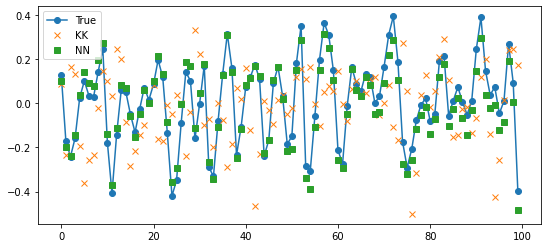

In [16]:
plt.figure(figsize=(9,4))
plt.plot(np.angle(sfm)[300:400],'-o',label='True')
plt.plot(phiTime[300:400],'x',label='KK')
plt.plot(phiTime_NN[300:400],'s',label='NN');
plt.legend();

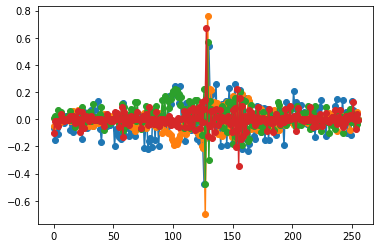

In [14]:
cw1 = model.layers[1].get_weights()
plt.plot(cw1[0],'-o');